In [1]:
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.ndimage
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path

In [33]:
# Two ways of computing the binomial distribution.
# https://en.wikipedia.org/wiki/Binomial_distribution
eps = 0.1
N = 10
n = 3
ids = np.arange(n)
combs = scipy.special.binom(N, ids).astype(int)
eps_1 = np.power(eps, ids)
eps_2 = np.power(1. - eps, N - ids)
pmf = combs * eps_1 * eps_2
cdf = np.sum(pmf)

rv = scipy.stats.binom(N, eps)
pmf, rv.pmf(ids), cdf, rv.cdf(n - 1)

(array([0.34867844, 0.38742049, 0.19371024]),
 array([0.34867844, 0.38742049, 0.19371024]),
 0.9298091736000003,
 0.9298091736)

In [2]:
# generating the binomial coefficent in few lines
# 1
# 1 1
# 1 2 1
# 1 3 3 1
# 1 4 6 4 1
# 1 5 10 10 5 1
# It seems better to use scipy.special.binom() over scipy.special.comb()
# scipy.special.binom() returns arrays of floats
n = np.array(sum([[i for j in range(i+1)] for i in range(5)], start=[]))
k = np.array(sum([[j for j in range(i+1)] for i in range(5)], start=[]))
n, k, scipy.special.binom(n, k).astype(int)

(array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4]),
 array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4]),
 array([1, 1, 1, 1, 2, 1, 1, 3, 3, 1, 1, 4, 6, 4, 1]))

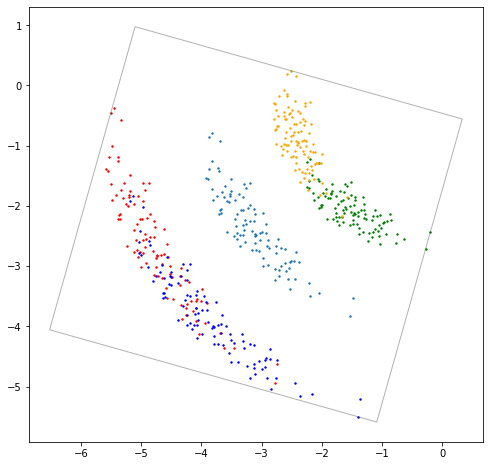

In [2]:
# Forming quadrilateral enclosing vertices of box.

def get_vertices_from_center(center, heading, lw):
    vertices = np.empty((8,))
    rot1 = np.array([
            [ np.cos(heading),  np.sin(heading)],
            [ np.sin(heading), -np.cos(heading)]])
    rot2 = np.array([
            [ np.cos(heading), -np.sin(heading)],
            [ np.sin(heading),  np.cos(heading)]])
    rot3 = np.array([
            [-np.cos(heading), -np.sin(heading)],
            [-np.sin(heading),  np.cos(heading)]])
    rot4 = np.array([
            [-np.cos(heading),  np.sin(heading)],
            [-np.sin(heading), -np.cos(heading)]])
    vertices[0:2] = center + 0.5 * rot1 @ lw
    vertices[2:4] = center + 0.5 * rot2 @ lw
    vertices[4:6] = center + 0.5 * rot3 @ lw
    vertices[6:8] = center + 0.5 * rot4 @ lw
    return vertices

def get_approx_union(theta, vertices):
    """Gets A_t, b_0 for the contraint set A_t x >= b_0
    vertices : np.array
        Vertices of shape (?, 8)
    
    Returns
    =======
    np.array
        A_t matrix of shape (4, 2)
    np.array
        b_0 vector of shape (4,)
    """
    At = np.array([
            [ np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]])
    At = np.concatenate((np.eye(2), -np.eye(2),)) @ At

    a0 = np.max(At @ vertices[:, 0:2].T, axis=1)
    a1 = np.max(At @ vertices[:, 2:4].T, axis=1)
    a2 = np.max(At @ vertices[:, 4:6].T, axis=1)
    a3 = np.max(At @ vertices[:, 6:8].T, axis=1)
    b0 = np.max(np.stack((a0, a1, a2, a3)), axis=0)
    return At, b0

def plot_h_polyhedron(ax, A, b, fc='none', ec='none', alpha=0.3):
    """
    A x < b is the H-representation
    [A; b], A x + b < 0 is the format for HalfspaceIntersection
    """
    Ab = np.concatenate((A, -b[...,None],), axis=-1)
    res = scipy.optimize.linprog([0, 0], A_ub=Ab[:,:2], b_ub=-Ab[:,2],
                                 bounds=(None, None))
    hs = scipy.spatial.HalfspaceIntersection(Ab, res.x)
    ch = scipy.spatial.ConvexHull(hs.intersections)
    x, y = zip(*hs.intersections[ch.vertices])
    ax.fill(x, y, fc=fc, ec=ec, alpha=0.3)

N = 100
lw = np.array([3.0, 1.5])
z = np.random.normal(loc=0., scale=0.5, size=(N,))
theta = (1/8 * np.pi) * z + np.pi + np.random.uniform(0., 2.)*np.pi
r = np.random.normal(loc=4., scale=0.2, size=(N,))
X = np.stack((r*np.cos(theta), r*np.sin(theta), theta), axis=1)


fig, ax = plt.subplots(figsize=(15,8))
axes = [ax]

axes[0].scatter(X[:,0], X[:,1], s=2)
axes[0].set_aspect('equal')

vertex_set = np.zeros((N, 8))
for idx in range(N):
    vertex_set[idx] = get_vertices_from_center(X[idx,:2], X[idx,2], lw)

X = vertex_set[:,0:2].T
axes[0].scatter(X[0], X[1], c='r', s=2)
X = vertex_set[:,2:4].T
axes[0].scatter(X[0], X[1], c='b', s=2)
X = vertex_set[:,4:6].T
axes[0].scatter(X[0], X[1], c='g', s=2)
X = vertex_set[:,6:8].T
axes[0].scatter(X[0], X[1], c='orange', s=2)
axes[0].set_aspect('equal')

"""Cluster the samples"""
mean_theta = np.mean(X[:,2])
A, b = get_approx_union(mean_theta, vertex_set)

plot_h_polyhedron(axes[0], A, b, ec='k', alpha=0.3)

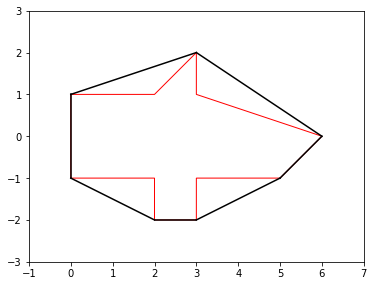

In [28]:
# Convex hull from polytope
# TODO: figure out how to find the largest inner convex hull.
poly = np.array([
    [  0, -1],
    [  2, -1],
    [  2, -2],
    [  3, -2],
    [  3, -1],
    [  5, -1],
    [  6,  0],
    [  3,  1],
    [  3,  2],
    [  2,  1],
    [  0,  1]])

fig, ax = plt.subplots(figsize=(6,6))

patch = patches.Polygon(poly, fill=False, color='r')
ax.add_patch(patch)
extent = np.concatenate([np.min(poly, axis=0), np.max(poly, axis=0)])

ax.set_xlim([extent[0] - 1, extent[2] + 1])
ax.set_ylim([extent[1] - 1, extent[3] + 1])
ax.set_aspect('equal')

ch = scipy.spatial.ConvexHull(poly, incremental=False, qhull_options=None)

for simplex in ch.simplices:
    ax.plot(poly[simplex, 0], poly[simplex, 1], 'k-')

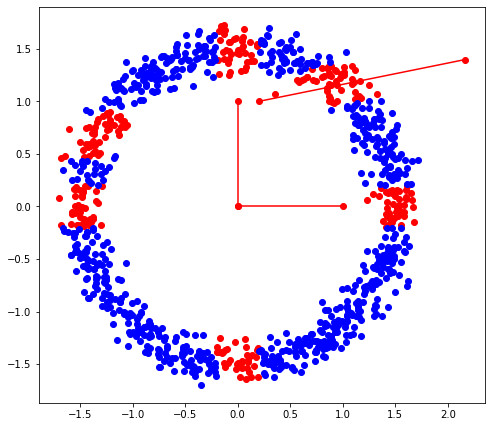

In [42]:
# Distance from line 
fig, ax = plt.subplots(figsize=(8, 8))

def distance_from_line_2d(points, x_start, y_start, x_end, y_end):
    """Get the distances from each point to a line spanned by line segment from
    (x_start, y_start) to (x_end, y_end). Works for horizontal and vertical lines.
    
    Parameters
    ==========
    points : np.array
        2D points of shape (n, 2)
    x_start : float
        Line segment component
    y_start : float
        Line segment component
    x_end : float
        Line segment component
    y_end : float
        Line segment component
    """
    return np.abs((x_end - x_start)*(y_start - points[:, 1]) - (x_start - points[:, 0])*(y_end - y_start)) \
            / np.sqrt((x_end - x_start)**2 + (y_end - y_start)**2)

TOL = 0.2
N = 1000
z = np.random.normal(loc=0., scale=0.5, size=(N,))
theta = 2 * np.pi * z
r = np.random.normal(loc=1.5, scale=0.1, size=(N,))
points = np.stack((r*np.cos(theta), r*np.sin(theta), theta), axis=1)

x_start, y_start = 0.2, 1.0
angle, radius = 0.2, 2
x_end, y_end = x_start + radius*np.cos(angle), y_start + radius*np.sin(angle)
S1 = np.array([[x_start, y_start], [x_end, y_end]])
distances = distance_from_line_2d(points, x_start, y_start, x_end, y_end)
mask_1 = distances < TOL
distances = distance_from_line_2d(points, 0, 0, 1, 0)
mask_2 = distances < TOL
distances = distance_from_line_2d(points, 0, 0, 0, 1)
mask_3 = distances < TOL

mask_and = mask_1 | mask_2 | mask_3
mask_not = ~mask_and

# plot line segments
ax.plot(S1[:,0], S1[:,1], '-ro')
ax.plot([0, 1], [0, 0], '-ro')
ax.plot([0, 0], [0, 1], '-ro')

ax.scatter(points[mask_and,0], points[mask_and,1], c='r')
ax.scatter(points[mask_not,0], points[mask_not,1], c='b')
ax.set_aspect('equal')

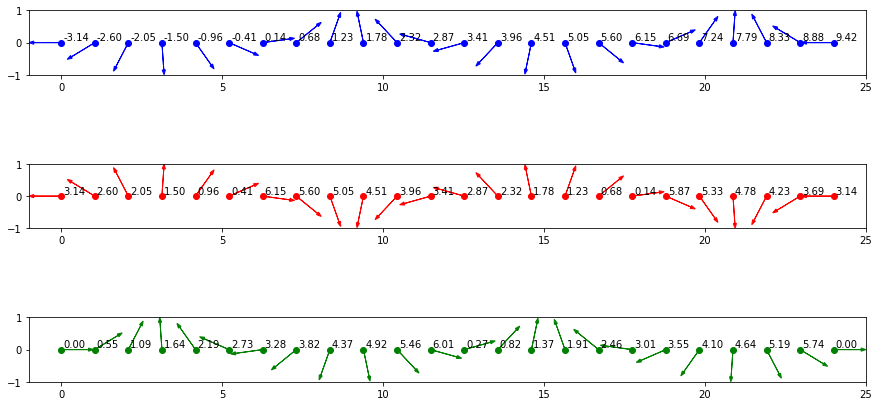

In [23]:
# Reflecting radian angles
n = 24
rs = np.linspace(-np.pi, 3*np.pi, n)
xs = np.linspace(0, n, n)

def plot_arrows(ax, xs, rs, color='b'):
    ax.scatter(xs, np.zeros(xs.shape), color=color)
    for i in range(n):
        x = xs[i]
        y = 0
        r = rs[i]
        rx = np.cos(r)
        ry = np.sin(r)
        ax.arrow(x, y, rx, ry, head_width=0.1, length_includes_head=True, color=color)
        ax.text(x + 0.06, y + 0.06, "{:.2f}".format(r))
    ax.set_aspect('equal')
    ax.set_xlim([-1, xs[-1] + 1])
    ax.set_ylim([-1, 1])

fig, axes = plt.subplots(3, 1, figsize=(15,8))
axes = axes.ravel()
plot_arrows(axes[0], xs, rs, color='b')

def reflect_radians_about_x_axis(r):
    r = (-r) % (2*np.pi)
    return r

plot_arrows(axes[1], xs, reflect_radians_about_x_axis(rs), color='r')

def reflect_radians_about_y_axis(r):
    r = (r + np.pi) % (2*np.pi)
    return r

plot_arrows(axes[2], xs, reflect_radians_about_y_axis(rs), color='g')

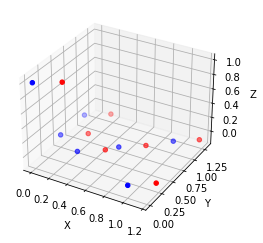

In [4]:
# translate points using transformation matrix
def create_translation_mtx(x, y, z):
    return np.array([
            [1, 0, 0, x],
            [0, 1, 0, y],
            [0, 0, 1, z],
            [0, 0, 0, 1]])

points = np.array([
    [0,  1,  0],
    [1,  0,  0],
    [0,  0,  1],
    [1,  1,  0],
    [0.3,0.3,0],
    [0.6,0.6,0],
    [0,  0.5,0],])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

points = points.T
ax.scatter(points[0], points[1], points[2], c='blue')
points = points.T

mtx = create_translation_mtx(0.15, 0.3, -0.1)
points = np.pad(points, [(0, 0), (0, 1)], mode='constant', constant_values=1)
points = (mtx @ points.T).T
points = points[:,:3]

points = points.T
ax.scatter(points[0], points[1], points[2], c='red')
points = points.T

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
None

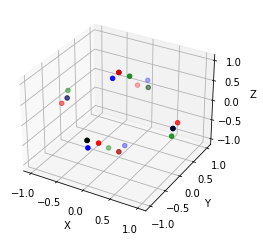

In [5]:
# translate points using transformation matrix
def create_x_rotation_mtx(a):
    """a is roll"""
    return np.array([
            [1, 0,          0,         0],
            [0, np.cos(a), -np.sin(a), 0],
            [0, np.sin(a),  np.cos(a), 0],
            [0, 0,          0,         1]])

def create_y_rotation_mtx(b):
    """b is pitch"""
    return np.array([
            [ np.cos(b), 0, np.sin(b), 0],
            [ 0,         1, 0,         0],
            [-np.sin(b), 0, np.cos(b), 0],
            [ 0,         0, 0,         1]])

def create_z_rotation_mtx(c):
    """c is yaw"""
    return np.array([
            [np.cos(c), -np.sin(c), 0, 0],
            [np.sin(c),  np.cos(c), 0, 0],
            [0,          0,         1, 0],
            [0,          0,         0, 1]])

points = np.array([
    [ 0,   1,  0],
    [ 1,   0,  0],
    [ 0,   0,  1],
    [ 0,  -1,  0],
    [-1,  0,   0],
    [ 0,  0,  -1],])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mtx = create_z_rotation_mtx(0.2)
p = np.pad(points, [(0, 0), (0, 1)],
                mode='constant', constant_values=1)
p = (mtx @ p.T).T
p = p[:,:3]

p = p.T
ax.scatter(p[0], p[1], p[2], c='red', marker='o')

mtx = create_x_rotation_mtx(0.2)
p = np.pad(points, [(0, 0), (0, 1)],
                mode='constant', constant_values=1)
p = (mtx @ p.T).T
p = p[:,:3]

p = p.T
ax.scatter(p[0], p[1], p[2], c='blue', marker='o')

mtx = create_y_rotation_mtx(0.2)
p = np.pad(points, [(0, 0), (0, 1)],
                mode='constant', constant_values=1)
p = (mtx @ p.T).T
p = p[:,:3]

p = p.T
ax.scatter(p[0], p[1], p[2], c='green', marker='o')

points = points.T
ax.scatter(points[0], points[1], points[2], c='black')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
None

(2, 1906) (2, 1890)
(2, 3796)
(72, 96)
(72, 96, 3)


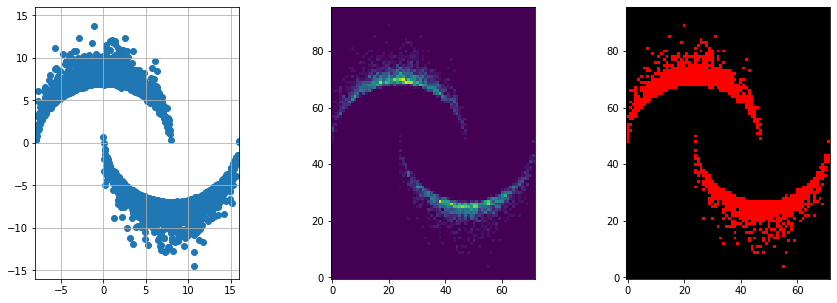

In [6]:
# Generating the two moons dataset
# Forming 2D histograms and 2D bitmaps; plotting histograms and bitmaps

N = 2000
sz = 8
sigma = 0.7
x = np.random.normal(loc=0., scale=sz / 2., size=(N,))
x = x[x**2 < sz**2]
y = np.sqrt(sz**2 - x**2) \
        + np.random.lognormal(mean=0, sigma=sigma, size=(x.size,)) \
        - np.exp(sigma**2 / 2.)
X1 = np.array([x, y])
X = X1

x = np.random.normal(loc=0., scale=sz / 2., size=(N,)) + sz
x = x[(x - sz)**2 < sz**2]
y = -np.sqrt(sz**2 - (x - sz)**2) \
        - np.random.lognormal(mean=0., sigma=sigma, size=(x.size,)) \
        + np.exp(sigma**2 / 2.)
X2 = np.array([x, y])
X = np.concatenate((X1, X2), axis=1)
print(X1.shape, X2.shape)
print(X.shape)

x_min = int(-sz)
x_max = int(2*sz)
y_min = int(-2*sz)
y_max = int(2*sz)

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes = axes.T
axes[0].scatter(X[0] ,X[1])
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])
axes[0].set_aspect('equal')
axes[0].grid()

bins= [
    int( 3*(x_max - x_min) ),
    int( 3*(y_max - y_min) )]

# Create and display histogram
hist, xedges, yedges = np.histogram2d(X[0], X[1], bins=bins, range=[[x_min, x_max], [y_min, y_max]])
print(hist.shape)
axes[1].imshow(hist.T, origin='lower', interpolation='none')
bitmap = hist.copy()
# Create and display bitmap
bitmap[bitmap > 0.] = 255.
bitmap = np.stack((bitmap, np.zeros(bitmap.shape), np.zeros(bitmap.shape)), axis=-1)
bitmap = bitmap.astype(np.uint8)
print(bitmap.shape)
# Axes.show() expects (M, N, 3): an image with RGB values (0-1 float or 0-255 int)
axes[2].imshow(bitmap.swapaxes(0, 1), origin='lower', interpolation='none')

In [7]:
# Cartesian product of multiple arrays

# Based on:
# https://stackoverflow.com/questions/11144513/cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

x = [np.arange(3), np.arange(2) + 1, np.arange(2) - 1]
print(x)
print()
print( cartesian_product(*x) )
print()

# Cartesian product of two arrays
x, y = x[0], x[1]
print(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]))

[array([0, 1, 2]), array([1, 2]), array([-1,  0])]

[[ 0  1 -1]
 [ 0  1  0]
 [ 0  2 -1]
 [ 0  2  0]
 [ 1  1 -1]
 [ 1  1  0]
 [ 1  2 -1]
 [ 1  2  0]
 [ 2  1 -1]
 [ 2  1  0]
 [ 2  2 -1]
 [ 2  2  0]]

[[0 1]
 [1 1]
 [2 1]
 [0 2]
 [1 2]
 [2 2]]


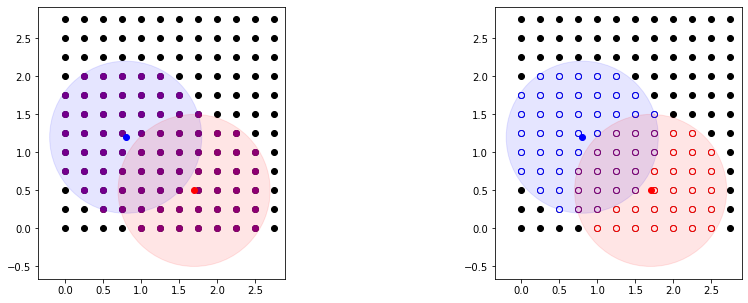

In [8]:
# select points in X that are unit 1 close to points in Y
# uses scipy.spatial.distance_matrix()
N = 12
x, y = np.arange(N) / 4., np.arange(N) / 4.
X = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

Y = np.array([
    [0.8, 1.2],
    [1.7, 0.5]])

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.ravel()
for ax in axes:
    ax.scatter(X.T[0], X.T[1], c='k')

    circ1 = plt.Circle(Y[0], 1, color='b', alpha=0.1)
    ax.add_patch(circ1)
    ax.plot(Y[0][0], Y[0][1], 'bo')

    circ1 = plt.Circle(Y[1], 1, color='r', alpha=0.1)
    ax.add_patch(circ1)
    ax.plot(Y[1][0], Y[1][1], 'ro')

# dist is a (number of points in X, number of points in Y)
# dist[i, j] is the distance from point X[i] to Y[j] 
dist = scipy.spatial.distance_matrix(X, Y)
mask = np.min(dist, axis=1) < 1
K = X[mask]
axes[0].scatter(K.T[0], K.T[1], c='purple')
blue_mask = np.logical_and(dist[:,0] < 1, dist[:,1] >= 1)
red_mask  = np.logical_and(dist[:,1] < 1, dist[:,0] >= 1)
purple_mask = np.logical_and(dist[:,0] < 1, dist[:,1] < 1)
K = X[blue_mask]
axes[1].scatter(K.T[0], K.T[1], facecolors='white', edgecolors='b')
K = X[red_mask]
axes[1].scatter(K.T[0], K.T[1], facecolors='white', edgecolors='r')
K = X[purple_mask]
axes[1].scatter(K.T[0], K.T[1], facecolors='white', edgecolors='purple')

for ax in axes:
    ax.set_aspect('equal')

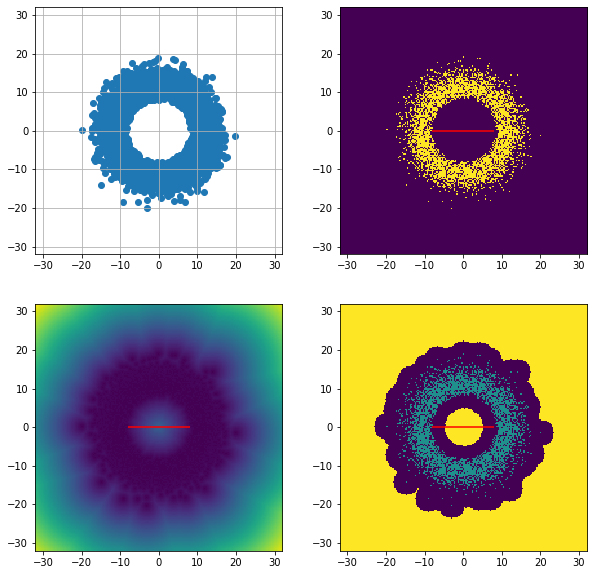

In [9]:
# Generating ring dataset
# Apply distance transform on negative space
n = 5000
r = 8
p = 10
cov = np.array([[p, 0], [0, p]])
X = np.random.multivariate_normal([0, 0], cov, n)
X = X + r*X / np.sqrt(np.square(X).sum(axis=1, keepdims=True))
X = X.T

x_min = -4*r
x_max = 4*r
y_min = -4*r
y_max = 4*r

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.reshape((-1))
axes[0].scatter(X[0] ,X[1])
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])
axes[0].set_aspect('equal')
axes[0].grid()

bins= [
    int( 3*(x_max - x_min) ),
    int( 3*(y_max - y_min) )]

# Create and display histogram
bitmap, xedges, yedges = np.histogram2d(X[0], X[1], bins=bins, range=[[x_min, x_max], [y_min, y_max]])

bitmap[bitmap > 0.] = 1.
axes[1].imshow(bitmap.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])
axes[1].add_collection(mc.LineCollection( [((-r,0), (r,0))] , colors='red'))


nbitmap = -bitmap + 1
# alternatively scipy.ndimage.distance_transform_cdt
dt = scipy.ndimage.distance_transform_edt(nbitmap)
axes[2].imshow(dt.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])
axes[2].add_collection(mc.LineCollection( [((-r,0), (r,0))] , colors='red'))

dist = 10
zbitmap = np.zeros(bitmap.shape)
zbitmap[dt > dist] = 1.
zbitmap[bitmap == 1.] = 0.5
axes[3].imshow(zbitmap.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])
axes[3].add_collection(mc.LineCollection( [((-r,0), (r,0))] , colors='red'))

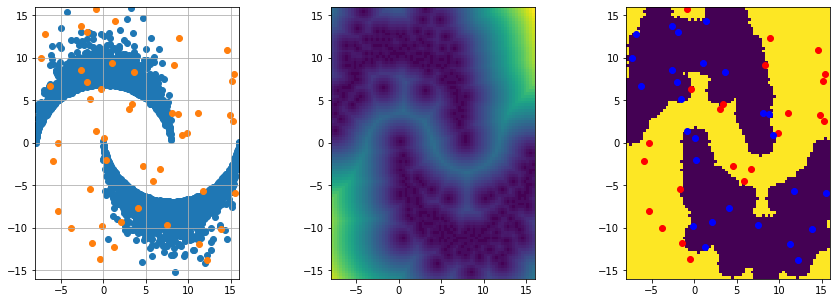

In [10]:
# Generating two moons dataset
# Filtering method that applys distance transform on negative space to select points Y epsilon close to point cloud X.

N = 5000
sz = 8
sigma = 0.7
x = np.random.normal(loc=0., scale=sz / 2., size=(N,))
x = x[x**2 < sz**2]
y = np.sqrt(sz**2 - x**2) \
        + np.random.lognormal(mean=0, sigma=sigma, size=(x.size,)) \
        - np.exp(sigma**2 / 2.)
X1 = np.array([x, y])
X = X1

x = np.random.normal(loc=0., scale=sz / 2., size=(N,)) + sz
x = x[(x - sz)**2 < sz**2]
y = -np.sqrt(sz**2 - (x - sz)**2) \
        - np.random.lognormal(mean=0., sigma=sigma, size=(x.size,)) \
        + np.exp(sigma**2 / 2.)
X2 = np.array([x, y])
X = np.concatenate((X1, X2), axis=1)

x_min = int(-sz)
x_max = int(2*sz)
y_min = int(-2*sz)
y_max = int(2*sz)
x_size = x_max - x_min
y_size = y_max - y_min

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.reshape((-1))
axes[0].scatter(X[0] ,X[1])
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])
axes[0].set_aspect('equal')
axes[0].grid()

bins= [
    int( 3*(x_max - x_min) ),
    int( 3*(y_max - y_min) )]

# Create and display histogram
bitmap, xedges, yedges = np.histogram2d(X[0], X[1], bins=bins, range=[[x_min, x_max], [y_min, y_max]])

nbitmap = -bitmap + 1
# alternatively scipy.ndimage.distance_transform_cdt
dt = scipy.ndimage.distance_transform_edt(nbitmap)
axes[1].imshow(dt.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])

dist = 5
zbitmap = np.zeros(bitmap.shape)
zbitmap[dt > dist] = 1.
axes[2].imshow(zbitmap.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])

shift = np.array([x_min, y_min])
Y = np.random.random((50, 2)) @ np.diag([x_size, y_size]) + shift
axes[0].scatter(Y.T[0], Y.T[1])

Yind = ( 3*(Y - shift) ).astype(int)
# alternative value selection
# val = np.array([dt[ids[0], ids[1]] for ids in Yind])
# alternative value selection
# val = dt[tuple(Yind.T)]
val = dt[ Yind.T[0], Yind.T[1] ]

Z = Y[val > dist].T
axes[2].scatter(Z[0], Z[1], c='r')
Z = Y[val <= dist].T
axes[2].scatter(Z[0], Z[1], c='b')

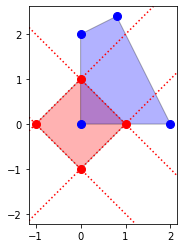

In [17]:
# Get feasible point inside a polyhedron with H-representation, and then find the vertices of the polyhedron
# and then plot the shape of the polygon
# See:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.HalfspaceIntersection.html
# https://www.mpt3.org/Geometry/Sets
from scipy.spatial import HalfspaceIntersection, ConvexHull

# First example
Ab = np.array([
    [-1, 1,-1],
    [ 1, 1,-1],
    [-1,-1,-1],
    [ 1,-1,-1]
])

# A = Ab[:,:2], b = Ab[:,2] and
# the constraint set is formed by Ax + b <= 0

# find any point inside A_ub x <= b_ub
res = scipy.optimize.linprog([0, 0], A_ub=Ab[:,:2], b_ub=-Ab[:,2])
# res has attributes x, fun, slack, con, success, status, nit, message

# Use intersections of half-spaces
hs = HalfspaceIntersection(Ab, res.x)
# Use the vertices of the convex hull, which for 2D are guaranteed to be in counterclockwise order
# Otherwise can't plot the polygon properly
ch = ConvexHull(hs.intersections)

fig, ax = plt.subplots()

x, y = zip(*hs.intersections[ch.vertices])
ax.plot(x, y, 'ro', markersize=8)
# patch = matplotlib.patches.Polygon(hs.intersections[ch.vertices], fill=True, color='r', alpha=0.3)
# ax.add_patch(patch)
ax.fill(x, y, fc='r', ec='k',alpha=0.3)

# Plot the boundary lines of halfspaces
A, b = Ab[:,:2], -Ab[:,2]
x0, x1 = 0, 1 # pick 2 points on the x intersection
y0 = b / A[:, 1] - 0*(A[:, 0] / A[:, 1]) # compute y = mx + b
y1 = b / A[:, 1] - 1*(A[:, 0] / A[:, 1])
ax.axline((x0, y0[0]), (x1, y1[0]), c='r', ls=':')
ax.axline((x0, y0[1]), (x1, y1[1]), c='r', ls=':')
ax.axline((x0, y0[2]), (x1, y1[2]), c='r', ls=':')
ax.axline((x0, y0[3]), (x1, y1[3]), c='r', ls=':')

# Second example
Ab = np.array([
        [-1, 0., 0.],
        [0., -1., 0.],
        [2., 1., -4.],
        [-0.5, 1., -2.]])

res = scipy.optimize.linprog([0, 0], A_ub=Ab[:,:2], b_ub=-Ab[:,2])
hs = HalfspaceIntersection(Ab, res.x)
ch = ConvexHull(hs.intersections)

x, y = zip(*hs.intersections[ch.vertices])
ax.plot(x, y, 'bo', markersize=8)
ax.fill(x, y, fc='b', ec='k',alpha=0.3)
ax.set_aspect('equal')

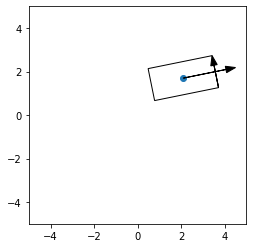

In [21]:
# Boxes and rotation matrices
x = np.array([2.1, 1.7])
lw = np.array([3.0, 1.5])
theta = 0.2 # 
rot1 = np.array([
        [ np.cos(theta),  np.sin(theta)],
        [ np.sin(theta), -np.cos(theta)]])
rot2 = np.array([
        [ np.cos(theta), -np.sin(theta)],
        [ np.sin(theta),  np.cos(theta)]])

rot3 = np.array([
        [-np.cos(theta), -np.sin(theta)],
        [-np.sin(theta),  np.cos(theta)]])
rot4 = np.array([
        [-np.cos(theta),  np.sin(theta)],
        [-np.sin(theta), -np.cos(theta)]])

vertices = np.empty((8,))
vertices[0:2] = x + 0.5 * rot1 @ lw
vertices[2:4] = x + 0.5 * rot2 @ lw
vertices[4:6] = x + 0.5 * rot3 @ lw
vertices[6:8] = x + 0.5 * rot4 @ lw

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(x[0], x[1])
ax.arrow(*x, 2*np.cos(theta), 2*np.sin(theta), head_width=0.3, color='k')
bb = patches.Polygon(vertices.reshape((-1,2,)), closed=True, color='k', fc='none')

dx = vertices[2:4] - vertices[0:2]
ax.arrow(vertices[0], vertices[1], dx[0], dx[1], length_includes_head=True, head_width=0.3, color='k')
ax.add_patch(bb)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
None

## Scratch

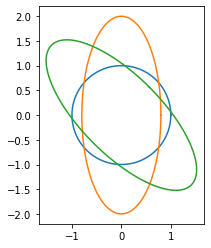

In [3]:
# Map a circle to a rotated ellipse

# generate points in unit circle
theta = np.linspace(0,2*np.pi, 100)
X = np.array([np.cos(theta), np.sin(theta)])

# plot unit circle
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(X[0], X[1])

# map the unit circle to ellipse using 2x2 matrix
A = np.array([[0.8, 0], [0, 2]])
Z = A @ X
ax.plot(Z[0], Z[1])

theta = np.pi / 4
A = np.array([[0.8, 0], [0, 2]])
R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]])
W = R @ A @ X
ax.plot(W[0], W[1])

None

In [95]:
# Computing the formulas in L-CSS paper
eps = 0.03
N = 2000 # number of samples
T = 4 # number of future prediction timesteps
L = 4 # number of halfspaces to form overapproximation
O = 10 # number of other vehicles

n_u = 2
n_b = L*T*O
n_c = T*n_u
ids = np.arange(n_c - 1)
rv = scipy.stats.binom(N, eps)
val = (2**n_b) * np.sum(rv.pmf(ids))

beta = 0.07
val, val < beta 

(4.36085736483304e+29, False)

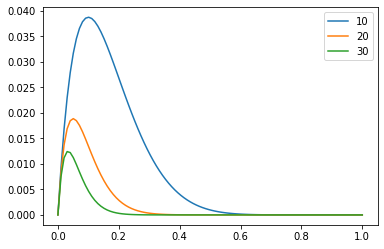

In [89]:
f = lambda eps, N: eps * (1 - eps)**(N - 1)
eps = np.linspace(0, 1, 100)
plt.plot(eps, f(eps, 10), label='10')
plt.plot(eps, f(eps, 20), label='20')
plt.plot(eps, f(eps, 30), label='30')
plt.legend()